# ODE  model of NeuroImaging with Bayesian Inference in Stan with cmdstanpy
:::

:post: April 12, 2024
:tags: ODE model in Nympyro
:category: Advanced, how-to
:author: Nina BALDY, INS, AMU, Marseille.
:acknowledgment: Meysam HASHEMI

:::

In [1]:
import os
import sys
import time
import errno
import timeit
import pathlib
import pickle

import numpy as np
import arviz as az
import matplotlib.pyplot as plt

from scipy.stats import norm
np.random.seed(0)

In [2]:
import cmdstanpy

In [3]:
main_path = str(pathlib.Path.cwd().parent)
sys.path.append(main_path)

In [4]:
from Helper.ERPhelper import *

In [5]:
print(f"Numpy version: {np.__version__}")
print(f"Arviz version: {az.__version__}")
print(f"Cmdstanpy version: {cmdstanpy.__version__}")

Numpy version: 1.26.4
Arviz version: 0.17.0
Cmdstanpy version: 1.1.0


In [6]:
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter(action="ignore", category=FutureWarning)

In [7]:
az.style.use("arviz-darkgrid")
colors_l = ["#A4C3D9", "#7B9DBF", "#52779F", "#2A537E"] 

In [8]:
cwd = os.getcwd()
output_dir = cwd + '/output_cmdstanpy/'
! mkdir -p $output_dir
forward_dir = main_path + '/ForwardModel/'

## Purpose

The purpose of this notebook is to demonstrate how to perform Bayesian inference using cmdstanpy interface to Stan's NUTS on a system of ordinary differential equations (ODEs). 

The accuracy and efficiency of different samplers (gradient-free and gradient-based) have been compared in DCM Refs [3,4]. The conclusion is that gradient-free samplers are not powerful enough for this model, and HMC is state-of-the-art for sampling on such high-dimensional models with (nonlinear) correlated parameters. Here we benefit from automatic algorithms and automatic gradient calculation in PPLs such as Stan. Nevertheless, multimodality is omnipresent for such high-dimensional parameters and nonlinear correlated parameters. 
   

### Key Conclusions

We propose solutions for convergence, such as increasing the max_tree_depth and decreasing target_accept_prob, to avoid issues with small step size. Remember that a smaller step size in HMC leads to heavier computational costs.

Importantly, we propose two main solutions to deal with multimodality:

    Initializing at the tail of the prior.

    Weighted stacking of the chains


In this demo, we focus on running the chains with initlization at the tail of prior, to reach convergence for all chains. For the Weighted stacking of the chains, see the advanced notebook name as MultimodalityRemedy.

Refs: 
    

2) https://www.sciencedirect.com/science/article/abs/pii/S1053811905008013


3) https://www.sciencedirect.com/science/article/pii/S1053811915001846


4) https://www.sciencedirect.com/science/article/pii/S1053811915006540

## Background

### Motivation

Ordinary differential equation models (ODEs) are used in a variety of science and engineering domains to model the time evolution of physical variables.  A natural choice to estimate the values and uncertainty of model parameters given experimental data is Bayesian inference.  However, ODEs can be challenging to specify and solve in the Bayesian setting, therefore, this notebook steps through multiple methods for solving an ODE inference problem using JAX's Odeint. Alternative is to use diffrax, which can be found in forward simuations in the repo. The neural mass model used in this example has often been used in dynamical cuasal modeling and other approaches to fit various neuroimaging data such as ERP/EEG/MEG.

### Neural Mass Model

The mode of Olivier David et al describes the interaction between theree neural populations of pyramidal (x9), 
inhibitory interneuron (x7) 
spiny-stellate cells (x1).

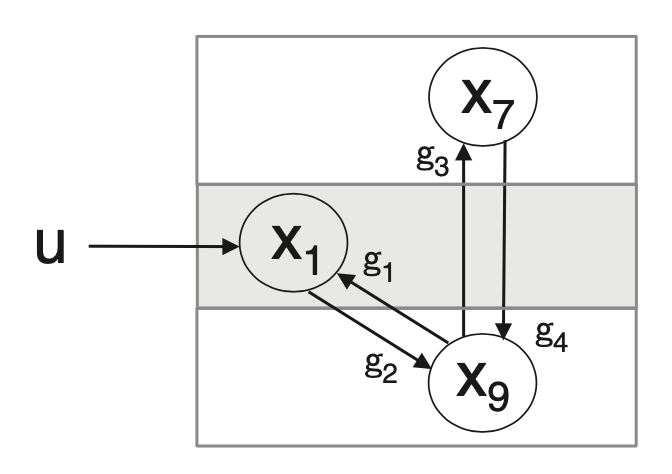

In [9]:
from IPython.display import Image
Image(filename=main_path + '/Images/model.png', width=400) 

This ODE given by:




\begin{equation}
    \begin{aligned}
    \dot x_1(t) &= x_4 (t) \\
    \dot x_2(t) &= x_5(t) \\
    \dot x_3(t) &= \dfrac{h_e}{\tau_e} \left( g_1 \left( 
    \dfrac{1}{\exp^{-0.56 x_9 (t - \delta)} + 1} - 0.5 \right) + u \right) - \dfrac{x_1(t)}{\tau_e^2} - \dfrac{2 x_4(t)}{\tau_e} \\
    \dot x_5(t) &= \dfrac{g_2 h_e}{\tau_e}  \left( 
    \dfrac{1}{\exp^{-0.56 x_1 (t - \delta)} + 1} -0.5 \right) - \dfrac{x_2(t)}{\tau_e^2} - \dfrac{2 x_5(t)}{\tau_e} \\
    \dot x_6(t) &= \dfrac{g_4 h_i}{\tau_i}  \left( 
    \dfrac{1}{\exp^{-0.56 x_7 (t - \delta)} + 1} -0.5 \right) - \dfrac{x_3(t)}{\tau_i^2} - \dfrac{2 x_6(t)}{\tau_i} \\
    \dot x_7(t) &= x_8(t) \\
    \dot x_8(t) &= \dfrac{g_3 h_e}{\tau_e}  \left( 
    \dfrac{1}{\exp^{-0.56 x_9 (t - \delta)} + 1} -0.5 \right) - \dfrac{x_7(t)}{\tau_e^2} - \dfrac{2 x_8(t)}{\tau_e} \\
    \dot x_9(t) &= x_5(t) - x_6(t)
\end{aligned}
\end{equation}




The state vector $X(t)=[x_1(t), ...x_9(t)]$ comprises the densities of activity of nerural populations.  Parameters $\boldsymbol{\theta}=[g_1, g_2, g_3, g_4, \delta,\tau_i, h_i, \tau_e, h_e, u ]$ are the unknowns that we wish to infer from experimental observations.  

$x(0)$ is the initial values of the states needed to solve the ODE, and are fixed to zero for all variables. 


The unknown model parameters which represent the following:  
* $g_1, g_2, g_3, g_4$ are connection strengths.
* $\delta$ is the intrinsic delay.
* $h_{e,i}$ are maximum amplitude of excitatory (e), and inhibitory (i) post-synaptic potential.
* $\tau_{e, i}$ are the excitatory (e), and inhibitory (i) rate-constant of the membrane,
* $u$  is the input to the neural population.

## Simulator

In [10]:
tend = 200.0
dt = 0.1
t0 = 0.0
ts = np.arange(t0, tend + dt, dt)
nt = ts.shape[0]

In [11]:
ns = 9
x_init=np.zeros((ns))

In [12]:
theta_true = np.array([0.42, 0.76, 0.15, 0.16, 12.13, 7.77, 27.87, 5.77, 1.63, 3.94])
n_params = theta_true.shape[0]

In [13]:
my_var_names = ['g_1', 'g_2', 'g_3', 'g_4', 'delta', 'tau_i', 'h_i', 'tau_e', 'h_e', 'u']

## Synthetic Observation

We assume that we only have accessto the activity of pyramidfal neurons, and for the sake of sppeding the computational time, we downsample the simuations.

In [14]:
#observation noise
sigma_true = 0.1 

In [15]:
#downsampling
ds=10

In [16]:
ts_obs=ts[::ds]

In [17]:
data_sim = { 'nt':nt//ds+1, 'ds': ds, 'ts': ts, 'ts_obs': ts_obs, 'dt': dt*ds, 'ns': ns, 
        'x_init': x_init, 'obs_err': sigma_true, 'n_params': n_params, 'alpha': -0.56}

for iprm, prm in enumerate(my_var_names) :
    data_sim[prm] = theta_true[iprm]

we can simulate the data in stan

In [18]:
model_name = 'ERPmodel_Stan'
stanfile = os.path.join(forward_dir, model_name + '.stan')
model = cmdstanpy.CmdStanModel(stan_file=stanfile)
model.compile()

In [19]:
forward_sim = model.sample(data=data_sim, iter_warmup=0, iter_sampling=1, chains=1)

17:32:30 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

17:32:30 - cmdstanpy - INFO - CmdStan done processing.


In [20]:
xpy_obs = forward_sim.stan_variable('x_hat_ppc').flatten()
xpy_model = forward_sim.stan_variable('x_hat_full').flatten()
xpy_model_ds = forward_sim.stan_variable('x_hat').flatten()

In [21]:
print(xpy_obs.shape)
print(xpy_model.shape)

(201,)
(2001,)


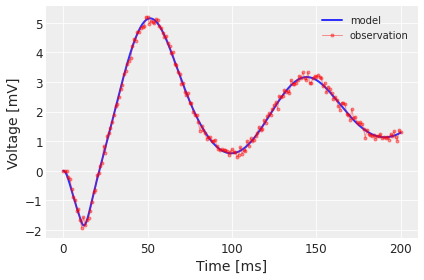

In [22]:
plot_observation(ts, xpy_model, ts_obs, xpy_obs)

In [23]:
data = data_sim.copy()
data['xpy_obs'] = xpy_obs
data['nt'] =  len(xpy_obs)

## Prior

Since all the parameters are positive, we place Gamma prior, according to Refs [3,4].
The Gamma distribution has two parametrization: numpy.random.gamma uses the shape and scale parametrization, while stan uses the shape and rate.

In [24]:
shape=[18.16, 29.9, 29.14, 30.77, 22.87, 34.67, 20.44, 33.02, 24.17, 23.62]
scale=[0.03, 0.02, 0.005, 0.007, 0.51, 0.23, 0.96, 0.16, 0.07, 0.13]
rate = 1. / np.array(scale)
prior_specs = dict(shape=shape, scale=scale, rate=rate)

In [25]:
data['prior_gamma_shape'] = prior_specs['shape']
data['prior_gamma_rate'] = prior_specs['rate']

In [26]:
model_name = 'DCM_ERP_PriorPred_GammaPrior'
stanfile = os.path.join(cwd, model_name + '.stan')
model = cmdstanpy.CmdStanModel(stan_file=stanfile)
model.compile()

In [27]:
with open(stanfile) as f :
    print(f.read())

functions {
  real Sigmodal(real x1,  real x2, real delta, real alpha ) {
       real S=(1.0/(1.0+exp(alpha*(x1-(delta*x2)))))-0.5;
    return S;
  }
}


data {
  int ns;                                       
  int nt;
  real dt; 
  int ds;
  real alpha;    
  row_vector[nt] xpy_obs;  
  int n_params; 
  row_vector[n_params] prior_gamma_shape; 
  row_vector[n_params] prior_gamma_rate; 
  real obs_err;
}


transformed data {
   vector[ns] x_init;
   x_init=rep_vector(0.,ns);
  real dt_full = dt/ds;
  int nt_full = (nt-1)*ds + 1;

}

parameters{
    real<lower=0.0>  g_1;
    real<lower=0.0>  g_2;
    real<lower=0.0>  g_3;
    real<lower=0.0>  g_4;
    real<lower=0.0>  delta;
    real<lower=0.0>  tau_i;
    real<lower=0.0>  h_i;
    real<lower=0.0>  tau_e;
    real<lower=0.0>  h_e;
    real<lower=0.0>  u;
}

transformed parameters {
}

model {

    g_1 ~ gamma(prior_gamma_shape[1], prior_gamma_rate[1]);
    g_2 ~ gamma(prior_gamma_shape[2], prior_gamma_rate[2]);
    g_3 ~ gamma(prior_gam

In [28]:
n_= 100 
prior_pred = model.sample(data=data, iter_warmup=1000, iter_sampling=n_)

17:32:31 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

17:32:32 - cmdstanpy - INFO - CmdStan done processing.
17:32:32 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: gamma_lpdf: Random variable is inf, but must be positive finite! (in '/mnt/data/tng/phd/DCM/DCM_ERP_new/github/Stan/NMM_EPR_Euler_full_ODE_PriorPred_GammaPrior.stan', line 50, column 4 to column 59)
Exception: gamma_lpdf: Random variable is inf, but must be positive finite! (in '/mnt/data/tng/phd/DCM/DCM_ERP_new/github/Stan/NMM_EPR_Euler_full_ODE_PriorPred_GammaPrior.stan', line 49, column 4 to column 59)
Exception: gamma_lpdf: Random variable is 0, but must be positive finite! (in '/mnt/data/tng/phd/DCM/DCM_ERP_new/github/Stan/NMM_EPR_Euler_full_ODE_PriorPred_GammaPrior.stan', line 50, column 4 to column 59)
Exception: gamma_lpdf: Random variable is inf, but must be positive finite! (in '/mnt/data/tng/phd/DCM/DCM_ERP_new/github/Stan/NMM_EPR_Euler_full_ODE_PriorPred_GammaPrior.stan', line 49, column 4 to column 59)
Consider re-running with show_console=Tru

In [29]:
prior_pred_samples = prior_pred.stan_variables()

In [30]:
prior_predictions = {'xpy_model': prior_pred_samples['x_hat']}
for key in my_var_names :
    prior_predictions[key] = prior_pred_samples[key]

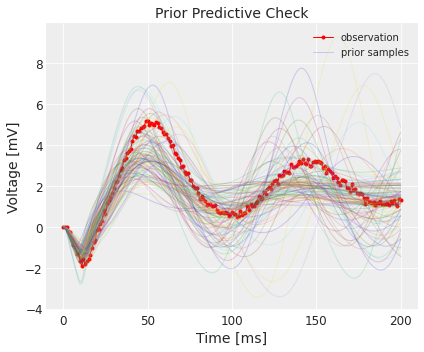

In [31]:
title='Prior Predictive Check'
plot_priorcheck(ts_obs, xpy_obs, prior_predictions, n_, title)

## NUTS sampling 

Due to large dimentionality of problem and the nonlinear relation between parameeters, the multimodality is omnipresence in this case. In the follwing , we run 4 NUTS chains with default configurations that operates across diverse problems, but not necessarliy leads to convergence. Then we tune the algorithmic parameters for better convergence, however, resulting in multimodality. Finaly, we propose the weighted stacking the chains as a solution to deal with this challenge. 

In [32]:
model_name = 'DCM_ERP_sampling_GammaPrior'
stanfile = os.path.join(cwd, model_name + '.stan')
model = cmdstanpy.CmdStanModel(stan_file=stanfile)
model.compile()

17:32:34 - cmdstanpy - INFO - compiling stan file /mnt/data/tng/phd/DCM/DCM_ERP_new/github/Stan/NMM_EPR_Euler_full_ODE_sampling_GammaPrior.stan to exe file /mnt/data/tng/phd/DCM/DCM_ERP_new/github/Stan/NMM_EPR_Euler_full_ODE_sampling_GammaPrior
17:32:45 - cmdstanpy - INFO - compiled model executable: /mnt/data/tng/phd/DCM/DCM_ERP_new/github/Stan/NMM_EPR_Euler_full_ODE_sampling_GammaPrior


In [38]:
with open(stanfile) as f :
    print(f.read())

functions {
  real Sigmodal(real x1,  real x2, real delta, real alpha ) {
       real S=(1.0/(1.0+exp(alpha*(x1-(delta*x2)))))-0.5;
    return S;
  }
}


data {
  int ns;                                       
  int nt;
  real dt; 
  int ds;
  real alpha;    
  row_vector[nt] xpy_obs;  
  int n_params; 
  row_vector[n_params] prior_gamma_shape; 
  row_vector[n_params] prior_gamma_rate; 
  real obs_err;
}


transformed data {
   vector[ns] x_init;
   x_init=rep_vector(0.,ns);
  real dt_full = dt/ds;
  int nt_full = (nt-1)*ds + 1;

}

parameters{
    real<lower=0.0>  g_1;
    real<lower=0.0>  g_2;
    real<lower=0.0>  g_3;
    real<lower=0.0>  g_4;
    real<lower=0.0>  delta;
    real<lower=0.0>  tau_i;
    real<lower=0.0>  h_i;
    real<lower=0.0>  tau_e;
    real<lower=0.0>  h_e;
    real<lower=0.0>  u;
}

transformed parameters {
}

model {

    matrix[ns, nt_full] x;
    vector[ns] dx;
    array[nt] int nt_indexing = linspaced_int_array(nt, 1, nt_full);
    row_vector[nt] x_hat;    


In [39]:
n_warmup, n_samples, n_chains = 200, 200, 4

In [40]:
output_fit_dir = output_dir + 'output_hmc_' + model_name + '_multimodal'

run NUTS with default parameter values and default initialization leads in multimodality

In [41]:
start = time.time()
hmc_fit = model.sample(data=data, iter_warmup=n_warmup, iter_sampling=n_samples, chains=n_chains,
                       max_treedepth=10,
                       output_dir=output_fit_dir)
end = time.time()
print(end - start, ' seconds')

15:43:14 - cmdstanpy - INFO - created output directory: /mnt/data/tng/phd/DCM/DCM_ERP_new/output_cmdstanpy/output_hmc_NMM_EPR_Euler_full_ODE_sampling_GammaPrior_multimodal
15:43:14 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

16:04:03 - cmdstanpy - INFO - CmdStan done processing.
16:04:03 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: gamma_lpdf: Random variable is inf, but must be positive finite! (in '/mnt/data/tng/phd/DCM/DCM_ERP_new/stan_models/NMM_EPR_Euler_full_ODE_sampling_GammaPrior.stan', line 56, column 4 to column 59)
	Exception: gamma_lpdf: Random variable is inf, but must be positive finite! (in '/mnt/data/tng/phd/DCM/DCM_ERP_new/stan_models/NMM_EPR_Euler_full_ODE_sampling_GammaPrior.stan', line 56, column 4 to column 59)
	Exception: gamma_lpdf: Random variable is inf, but must be positive finite! (in '/mnt/data/tng/phd/DCM/DCM_ERP_new/stan_models/NMM_EPR_Euler_full_ODE_sampling_GammaPrior.stan', line 56, column 4 to column 59)
	Exception: gamma_lpdf: Random variable is inf, but must be positive finite! (in '/mnt/data/tng/phd/DCM/DCM_ERP_new/stan_models/NMM_EPR_Euler_full_ODE_sampling_GammaPrior.stan', line 62, column 4 to column 61)
	Exception: normal_lpdf: Location parame

16:04:04 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 1 had 160 iterations at max treedepth (80.0%)
	Chain 2 had 110 iterations at max treedepth (55.0%)
	Chain 3 had 200 iterations at max treedepth (100.0%)
	Chain 4 had 149 iterations at max treedepth (74.5%)
	Use function "diagnose()" to see further information.


1249.588599205017  seconds


NOTES: By this setup, the chains may converge or not. We can see that there are samples that hitted the max tree-depth, which may lead to mature convergence as for those the chains trace back to the initial condition. The convergence can be checked by monitoring the \hat R, close to 1 as a rule of thumb, also the Rank Plot, and Effective Sample Size (EES) which we will see in the following.

In [42]:
az_obj = az.from_cmdstan(output_fit_dir  + '/*.csv')

In [43]:
az.summary(az_obj, var_names=my_var_names)

mean      sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
g_1     1.638   1.172   0.351    3.304      0.561    0.427       5.0   
g_2     0.500   0.162   0.282    0.748      0.075    0.056       6.0   
g_3     0.232   0.137   0.110    0.462      0.066    0.051       5.0   
g_4     0.321   0.193   0.164    0.638      0.090    0.068       8.0   
delta  16.798  15.345   0.331   42.032      7.517    5.740       5.0   
tau_i   6.643   3.850   0.382   11.026      1.886    1.440       5.0   
h_i    15.096   6.614   5.346   23.918      3.010    2.272       6.0   
tau_e   7.632   4.084   4.407   14.864      1.999    1.526       5.0   
h_e     3.169   1.598   1.540    6.140      0.768    0.584       5.0   
u       3.591   2.530   0.020    7.051      1.224    0.933       5.0   

       ess_tail  r_hat  
g_1        24.0   2.68  
g_2        63.0   2.06  
g_3       129.0   2.24  
g_4        79.0   1.56  
delta      11.0   3.19  
tau_i       4.0   3.16  
h_i         4.0   1.92  
tau_e       4.0   3.07  
h_e        45.0   2.18  
u          15.0   3.17

In [44]:
lp = az_obj.sample_stats['lp'].to_numpy().flatten()
print('Expected log joint density: {:.2f}'.format(lp.mean()))

Expected log joint density: -3063.29


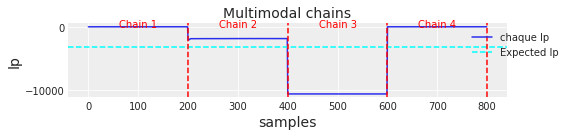

In [45]:
title='Multimodal chains'
plot_lp_chains(lp, n_chains, title)

In [46]:
chains_pooled = az_obj.posterior[my_var_names].to_array().values.reshape(n_params, -1)
params_map_pooled = calcula_map(chains_pooled)

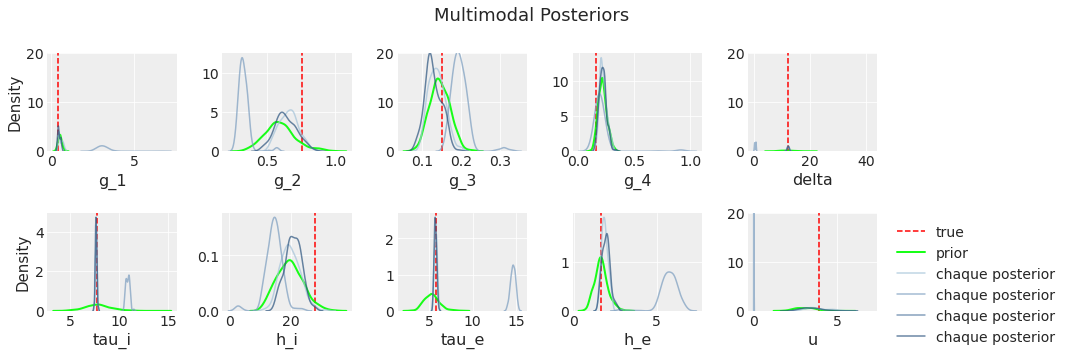

In [47]:
title="Multimodal Posteriors"
fig, ax = plot_posterior_multimodal(my_var_names, theta_true, prior_predictions, az_obj.posterior, title)
for a in ax.flatten() :
    if a.get_ylim()[1] > 20 :
        a.set_ylim([a.get_ylim()[0], 20])

### Pooled posterior of Naive NUTS

In [48]:
chains_pooled = az_obj.posterior[my_var_names].to_array().values.reshape(n_params, -1)
params_map_pooled=calcula_map(chains_pooled)

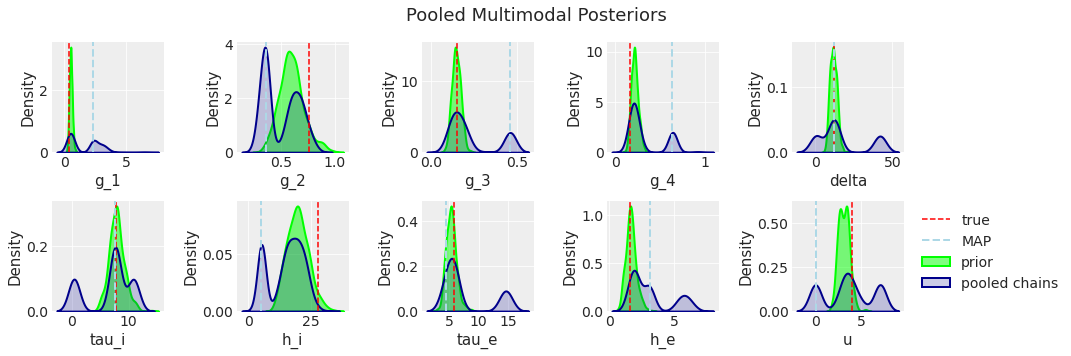

In [49]:
title="Pooled Multimodal Posteriors"
plot_posterior_pooled(my_var_names, theta_true, prior_predictions, chains_pooled, title)

### Fit and Posterior predictive check 

In [50]:
#to be able to use the plot function, we rename x_hat into xpy_model
az_obj.posterior['xpy_model'] = az_obj.posterior['x_hat']

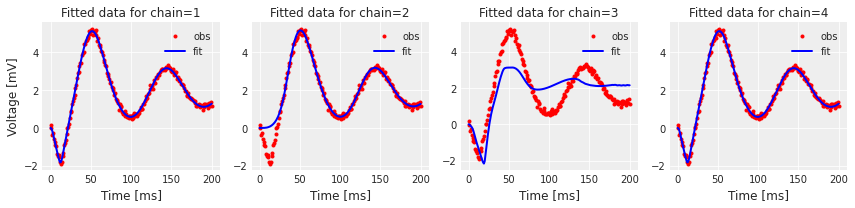

In [51]:
plot_fitted(data, az_obj.posterior)

In [52]:
ppc_= az_obj.posterior['x_hat_ppc']
xpy_per05_pooled=np.quantile(ppc_, 0.05, axis=(0, 1))
xpy_per95_pooled=np.quantile(ppc_, 0.95, axis=(0, 1))

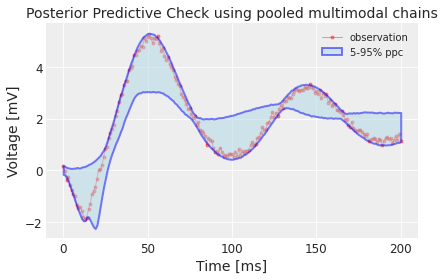

In [53]:
title='Posterior Predictive Check using pooled multimodal chains'
plot_posteriorcheck(data, xpy_per05_pooled, xpy_per95_pooled, title)

## 2) Weighted stacking as a remedy for multimodality

We compute post-hoc weights based on the expected log predictive density of the different chains, and weight samples by these weights to address multimodality of the output

We need to compute pointwise log prob and add it the the arviz object

In [54]:
pointwise_lp_list = [] 
for ichain in range(n_chains) :
    density_fit = norm(az_obj.posterior['x_hat'][ichain, :, :], sigma_true)
    logp = density_fit.logpdf(data['xpy_obs'])
    pointwise_lp_list.append(logp)
    
try :
    del az_obj.log_likelihood
except :
    pass 
az_obj.add_groups({'log_likelihood': dict(log_lik=np.array(pointwise_lp_list))})

In [55]:
name = []
post = []
for i in range(n_chains) :
    post.append(az_obj.sel(chain=[i]))
    name.append(str(i))
    
chains_dict = dict(zip(name, post))

Compute the stacking weights with arviz

In [56]:
comp_stack = az.compare(chains_dict, method='stacking')
comp_stack

rank      elpd_loo      p_loo     elpd_diff        weight          se  \
0     0    179.793295   4.422937      0.000000  1.000000e+00    8.216223   
3     1    179.760380   4.446001      0.032915  0.000000e+00    8.201361   
1     2  -1449.791388  25.773345   1629.584683  2.676708e-10  426.886752   
2     3 -10239.523074   7.439232  10419.316369  0.000000e+00  701.734152   

          dse  warning scale  
0    0.000000     True   log  
3    0.222995     True   log  
1  426.309429     True   log  
2  701.555536     True   log

In [57]:
stack_weights = np.array(comp_stack.sort_index()['weight'])
stack_weights

array([1.00000000e+00, 2.67670791e-10, 0.00000000e+00, 0.00000000e+00])

If not already have a posterior_predictive and observed_data groups, add them with following:

In [58]:
#copy posterior to posterior predictive and add observed_data to be able to use function weight_prediction of arviz
list_chains = list(chains_dict.values())
for ichain in range(len(list_chains)) :
    
    try :
        del list_chains[ichain].observed_data
    except :
        pass 
    list_chains[ichain].add_groups(posterior_predictive=list_chains[ichain].posterior.copy())
    
    try :
        del list_chains[ichain].observed_data
    except :
        pass 
    list_chains[ichain].add_groups({'observed_data': data})

In [59]:
w_post = az.weight_predictions(list_chains, stack_weights)
chains_stacked=w_post.posterior_predictive[my_var_names].to_array().values

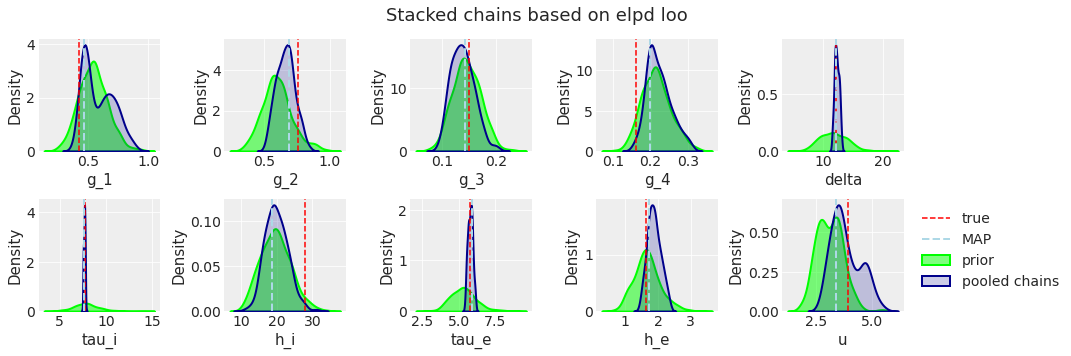

In [60]:
title='Stacked chains based on elpd loo'
plot_posterior_pooled(my_var_names, theta_true,  prior_predictions, chains_stacked, title)

### Posterior Predictive Check using stacked chains

In [61]:
joint_sample_, ppc_, xpy_per5_, xpy_per95_, x_map_= out_of_samples_ppc_values(data, ERP_JAXOdeintSimuator, chains_stacked, n_)

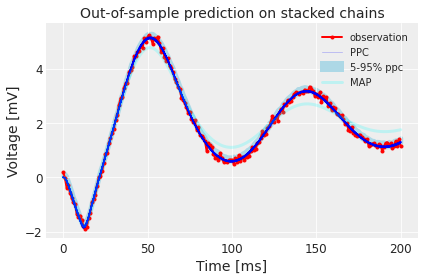

In [62]:
title='Out-of-sample prediction on stacked chains'
plot_out_of_sample_ppc_values(data, ERP_JAXOdeintSimuator,joint_sample_, xpy_per5_, xpy_per95_, x_map_, n_, title)

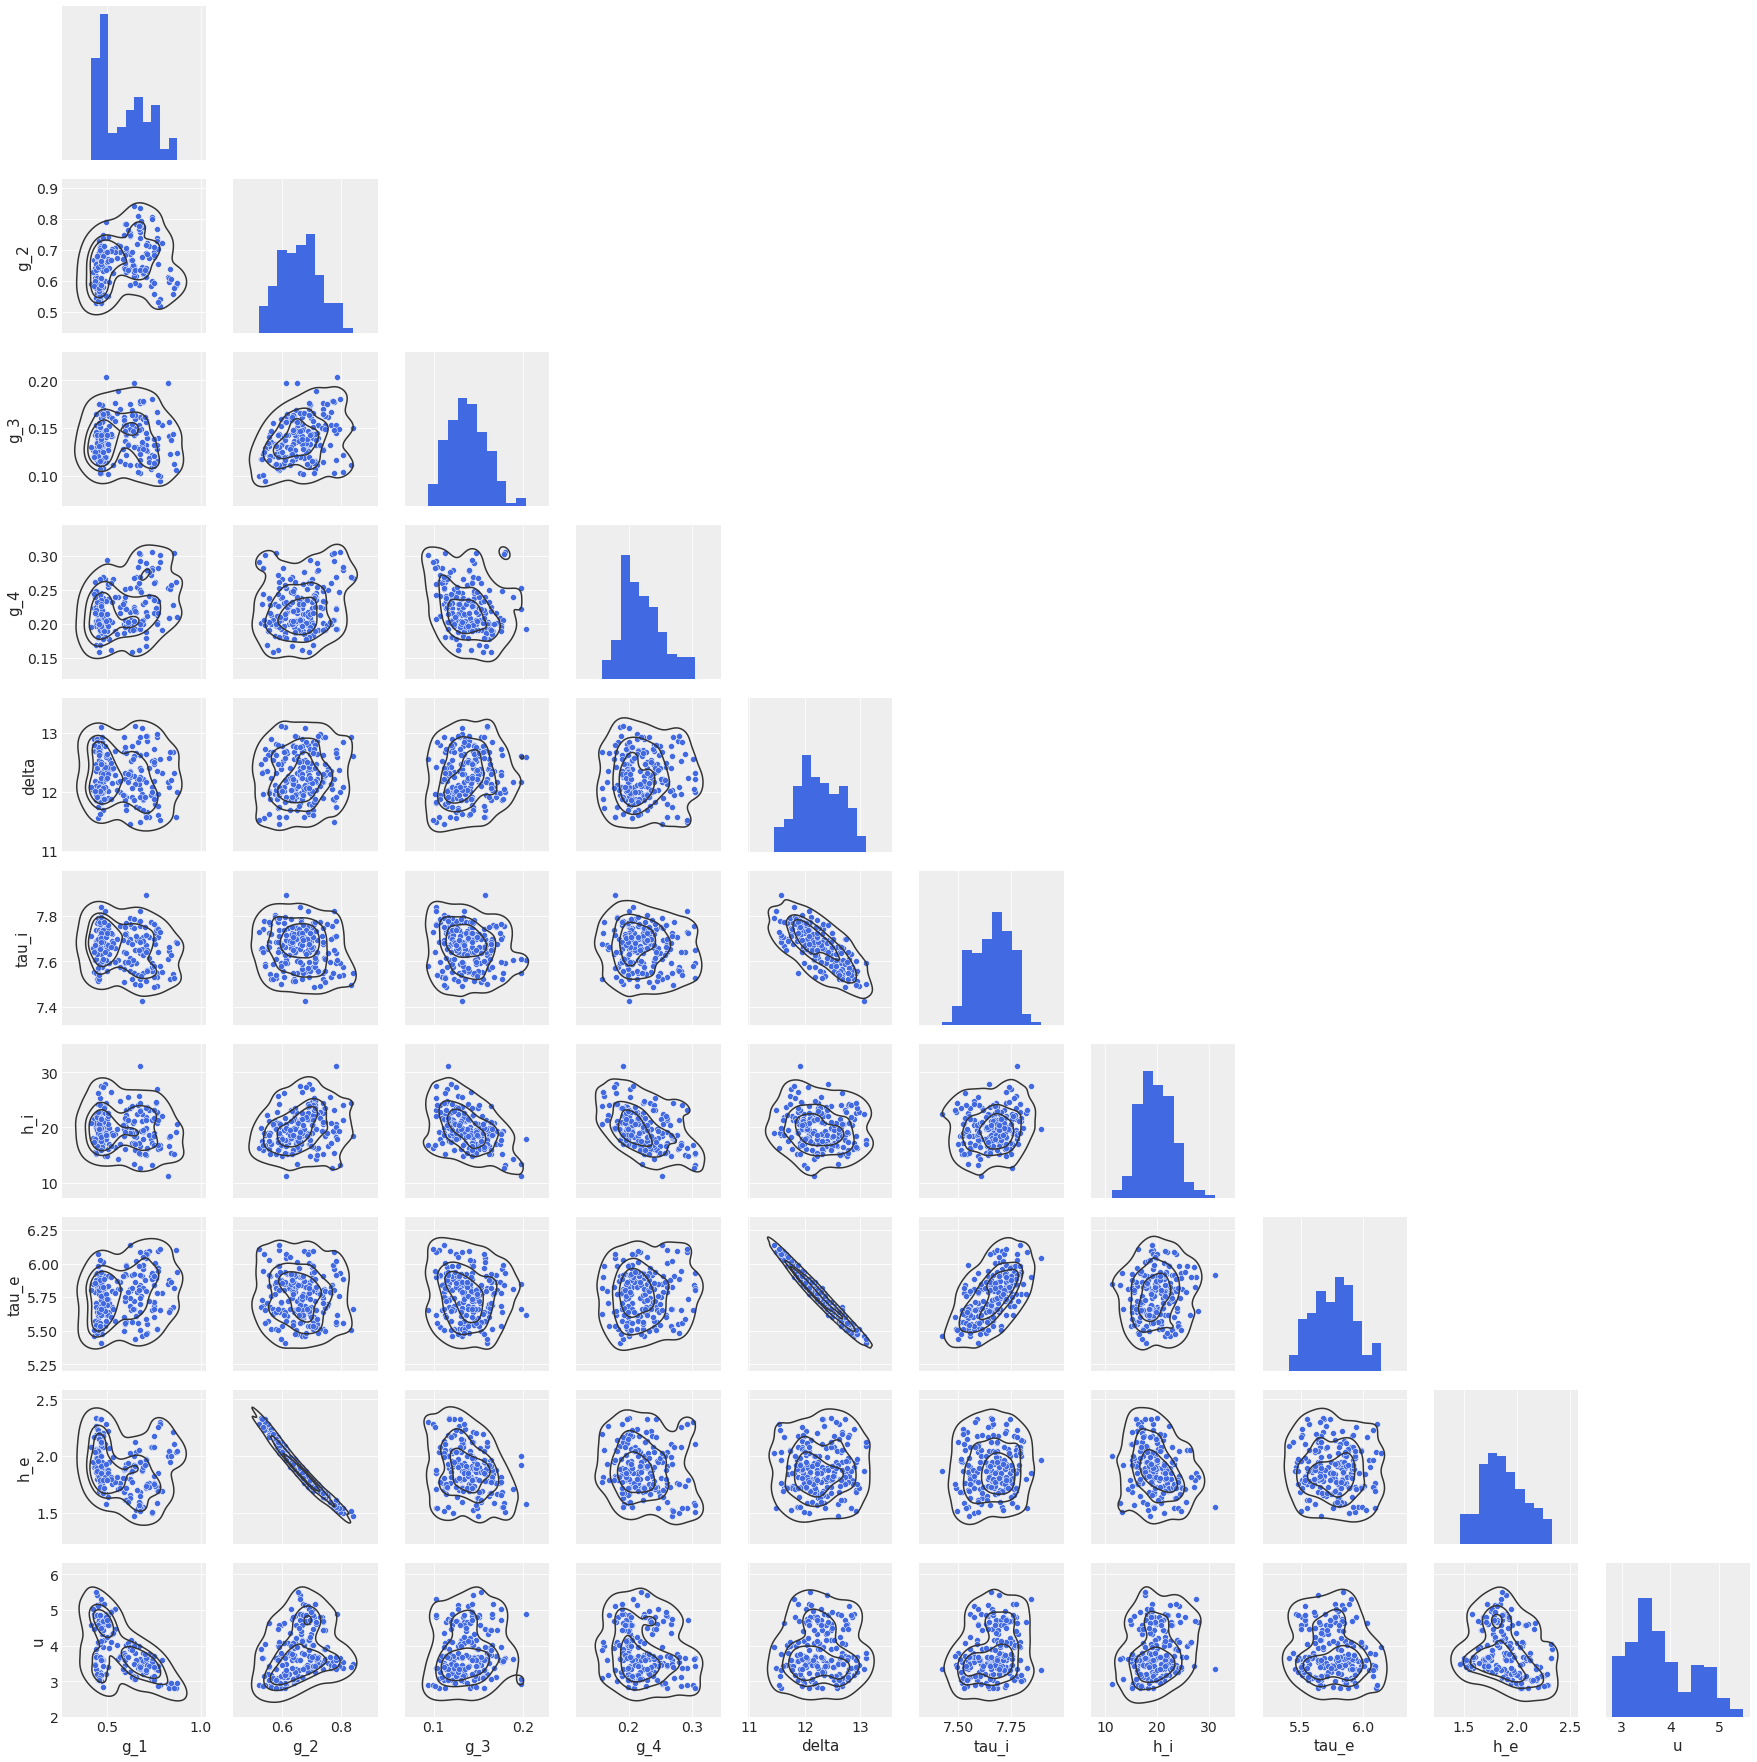

In [63]:
g = sns.PairGrid(w_post.posterior_predictive[my_var_names].to_pandas()[my_var_names], corner=True)
g.map_lower(sns.scatterplot, color='royalblue');
g.map_diag(plt.hist, color='royalblue');
g.map_lower(sns.kdeplot, levels=4, color=".2");

## 3)  Initializing NUTS in the tails of priors

Initializing the chains by sampling uniformly in the tails of priors yields convergence for all chains.

In [64]:
prior, low_prob_sample_vals, q_ = low_prob_sample(my_var_names, prior_predictions)

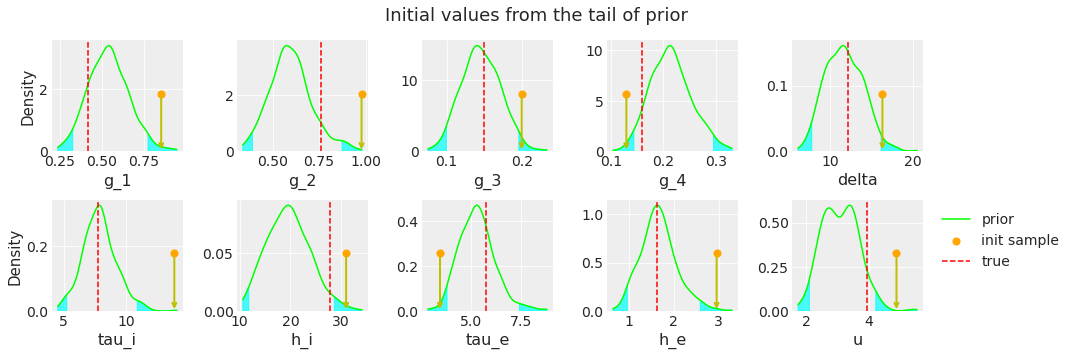

In [65]:
plot_prior_tail(my_var_names, theta_true, prior, low_prob_sample_vals, q_)

In [66]:
inits = dict(zip(my_var_names, low_prob_sample_vals))

In [67]:
n_warmup, n_samples, n_chains = 200, 200, 4

In [68]:
output_fit_dir = output_dir + 'output_hmc_' + model_name + '_initalized'

In [72]:
start = time.time()
hmc_fit = model.sample(data=data, iter_warmup=n_warmup, iter_sampling=n_samples, chains=n_chains,
                       max_treedepth=10, inits=inits,
                       output_dir=output_fit_dir)
end = time.time()
print(end - start, ' seconds')

16:45:44 - cmdstanpy - INFO - created output directory: /mnt/data/tng/phd/DCM/DCM_ERP_new/output_cmdstanpy/output_hmc_NMM_EPR_Euler_full_ODE_sampling_GammaPrior_initalized
16:45:44 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

16:59:27 - cmdstanpy - INFO - CmdStan done processing.
16:59:27 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: gamma_lpdf: Random variable is inf, but must be positive finite! (in '/mnt/data/tng/phd/DCM/DCM_ERP_new/stan_models/NMM_EPR_Euler_full_ODE_sampling_GammaPrior.stan', line 56, column 4 to column 59)
	Exception: gamma_lpdf: Random variable is inf, but must be positive finite! (in '/mnt/data/tng/phd/DCM/DCM_ERP_new/stan_models/NMM_EPR_Euler_full_ODE_sampling_GammaPrior.stan', line 56, column 4 to column 59)
	Exception: gamma_lpdf: Random variable is inf, but must be positive finite! (in '/mnt/data/tng/phd/DCM/DCM_ERP_new/stan_models/NMM_EPR_Euler_full_ODE_sampling_GammaPrior.stan', line 56, column 4 to column 59)
	Exception: gamma_lpdf: Random variable is 0, but must be positive finite! (in '/mnt/data/tng/phd/DCM/DCM_ERP_new/stan_models/NMM_EPR_Euler_full_ODE_sampling_GammaPrior.stan', line 57, column 4 to column 59)
	Exception: normal_lpdf: Location paramete


823.1900725364685  seconds


In [73]:
az_obj = az.from_cmdstan(output_fit_dir  + '/*.csv')

In [74]:
az.summary(az_obj, var_names=my_var_names)

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
g_1     0.516  0.126   0.279    0.747      0.004    0.003     780.0     445.0   
g_2     0.649  0.075   0.503    0.783      0.003    0.002     499.0     483.0   
g_3     0.138  0.021   0.098    0.174      0.001    0.001     709.0     631.0   
g_4     0.216  0.032   0.154    0.274      0.001    0.001     536.0     459.0   
delta  12.306  0.380  11.538   12.973      0.018    0.012     467.0     505.0   
tau_i   7.657  0.088   7.485    7.815      0.003    0.002     648.0     545.0   
h_i    20.030  3.268  14.272   26.347      0.136    0.097     582.0     510.0   
tau_e   5.741  0.162   5.437    6.046      0.007    0.005     486.0     558.0   
h_e     1.923  0.221   1.528    2.363      0.010    0.007     503.0     405.0   
u       3.524  0.629   2.448    4.805      0.024    0.017     745.0     445.0   

       r_hat  
g_1     1.00  
g_2     1.00  
g_3     1.00  
g_4     1.01  
delta   1.01  
tau_i   1.00  
h_i     1.00  
tau_e   1.01  
h_e     1.00  
u       1.01

In [75]:
lp = az_obj.sample_stats['lp'].to_numpy().flatten()
print('Expected log joint density: {:.2f}'.format(lp.mean()))

Expected log joint density: 65.35


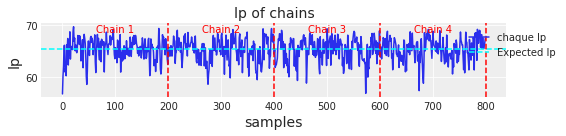

In [76]:
title='lp of chains'
plot_lp_chains(lp, n_chains, title)

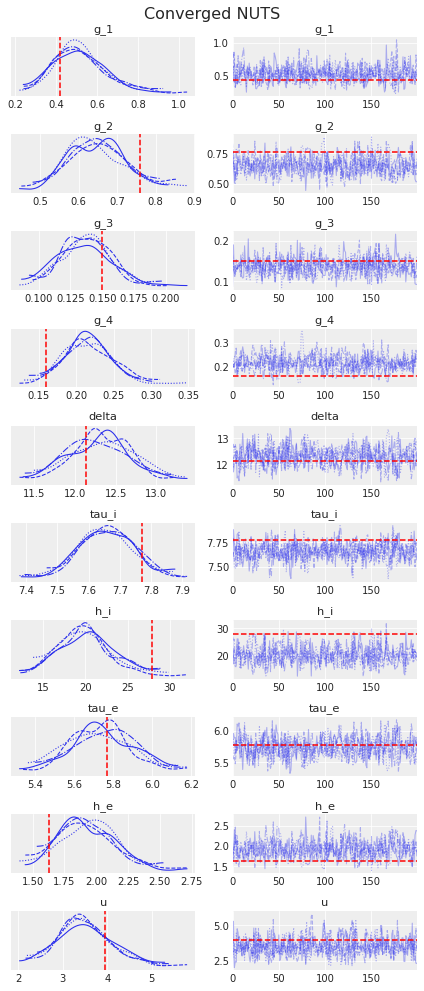

In [77]:
axes = az.plot_trace(
    az_obj,
    var_names=my_var_names,
    compact=True,
    kind="trace",
    backend_kwargs={"figsize": (6, 14), "layout": "constrained"},)

for ax, true_val in zip(axes[:, 0], theta_true):
    ax.axvline(x=true_val, color='red', linestyle='--')
for ax, true_val in zip(axes[:, 1], theta_true):
    ax.axhline(y=true_val, color='red', linestyle='--')
    
plt.gcf().suptitle("Converged NUTS", fontsize=16)
plt.tight_layout();

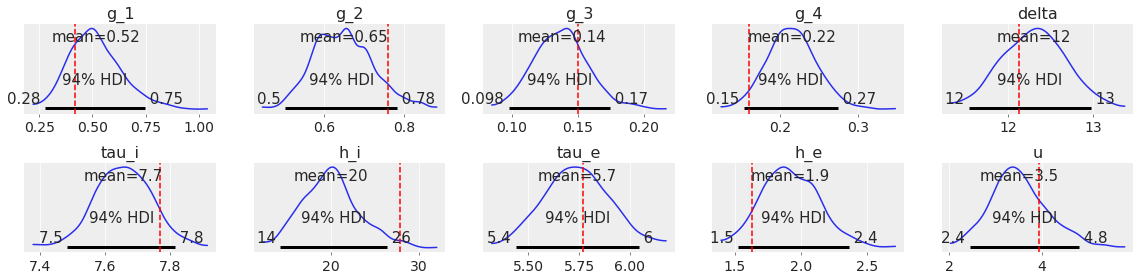

In [78]:
axes = az.plot_posterior(az_obj,
    var_names=my_var_names,
    backend_kwargs={"figsize": (16, 4), "layout": "constrained"},  grid=(2, 5))
    
for ax, true_value in zip(axes.ravel(), theta_true):
    ax.axvline(true_value, color='r', linestyle='--')

plt.tight_layout();

### Pooled posterior of convergenced NUTS

In [79]:
chains_pooled = az_obj.posterior[my_var_names].to_array().values.reshape(n_params, -1)
params_map_pooled=calcula_map(chains_pooled)

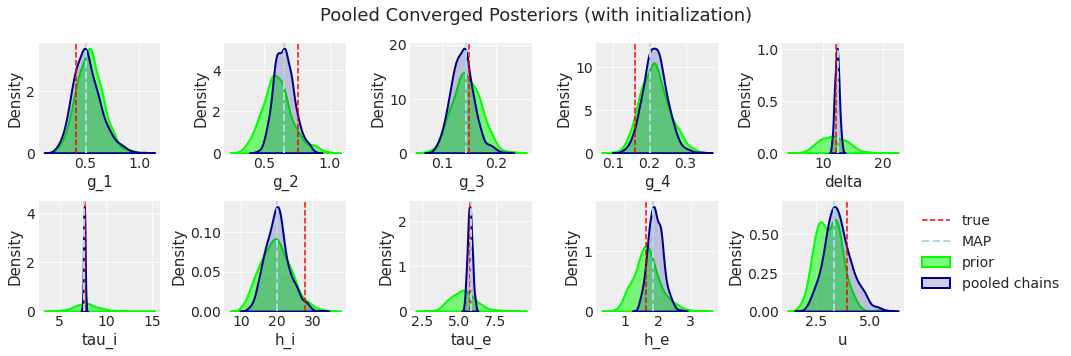

In [80]:
title='Pooled Converged Posteriors (with initialization)'
plot_posterior_pooled(my_var_names, theta_true, prior_predictions, chains_pooled, title)

In [81]:
rmse_prms = np.sqrt(np.mean((theta_true - az_obj.posterior[my_var_names].mean().to_array().values)**2))
rmse_prms

2.485860448075894

In [ ]:
pooled_az_4 = az_obj.sel(chain=range(4), draw=range(200)).stack({'pooled_draw': ["chain", "draw"]})
with open(output_dir + 'values_hmc_with_inits.pkl', 'wb') as f:
    pickle.dump(pooled_az_4.posterior[my_var_names].to_pandas(), f)

### More dignostics on convergenced NUTS

shwoing the rank plot as it should be uniform by convergence:

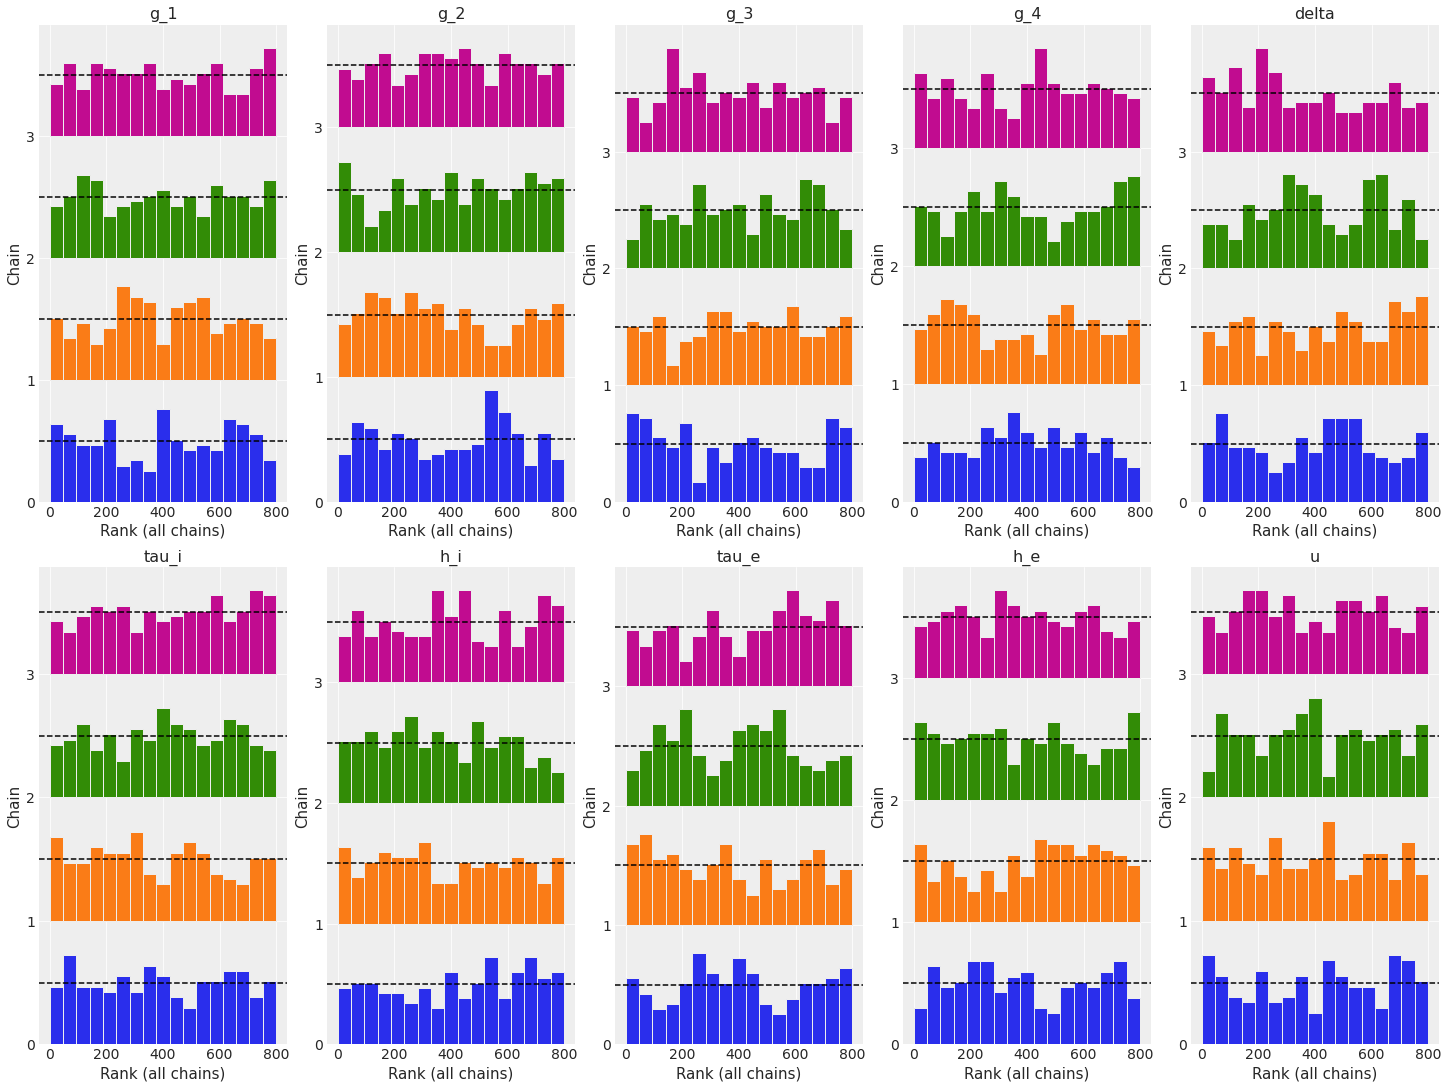

In [82]:
fig, ax = plt.subplots(ncols=5, nrows=2, figsize=(20, 15))
for iprm, prm in enumerate(my_var_names) :
    a = ax[iprm//5, iprm%5]
    az.plot_rank(az_obj, var_names=my_var_names[iprm], ax=a)

showing the effective number of samples, which should uniformly increase by convergence

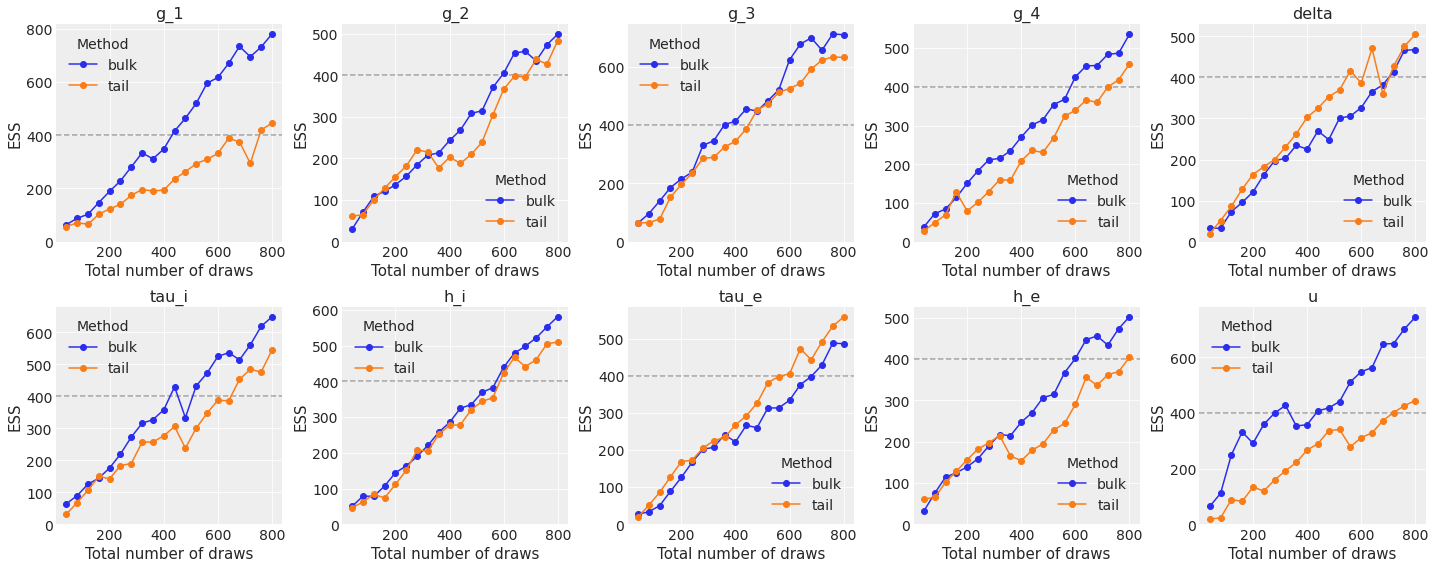

In [83]:
fig, ax = plt.subplots(ncols=5, nrows=2, figsize=(20, 8))
for iprm, prm in enumerate(my_var_names) :
    a = ax[iprm//5, iprm%5]
    az.plot_ess(az_obj, var_names=my_var_names[iprm], kind='evolution', ax=a)
fig.tight_layout()

### Relation between parameters

In [84]:
corr_vals=np.corrcoef(chains_pooled)

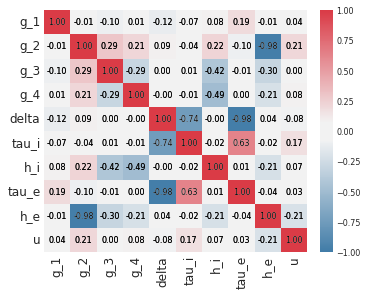

In [85]:
plot_corr(corr_vals, my_var_names)

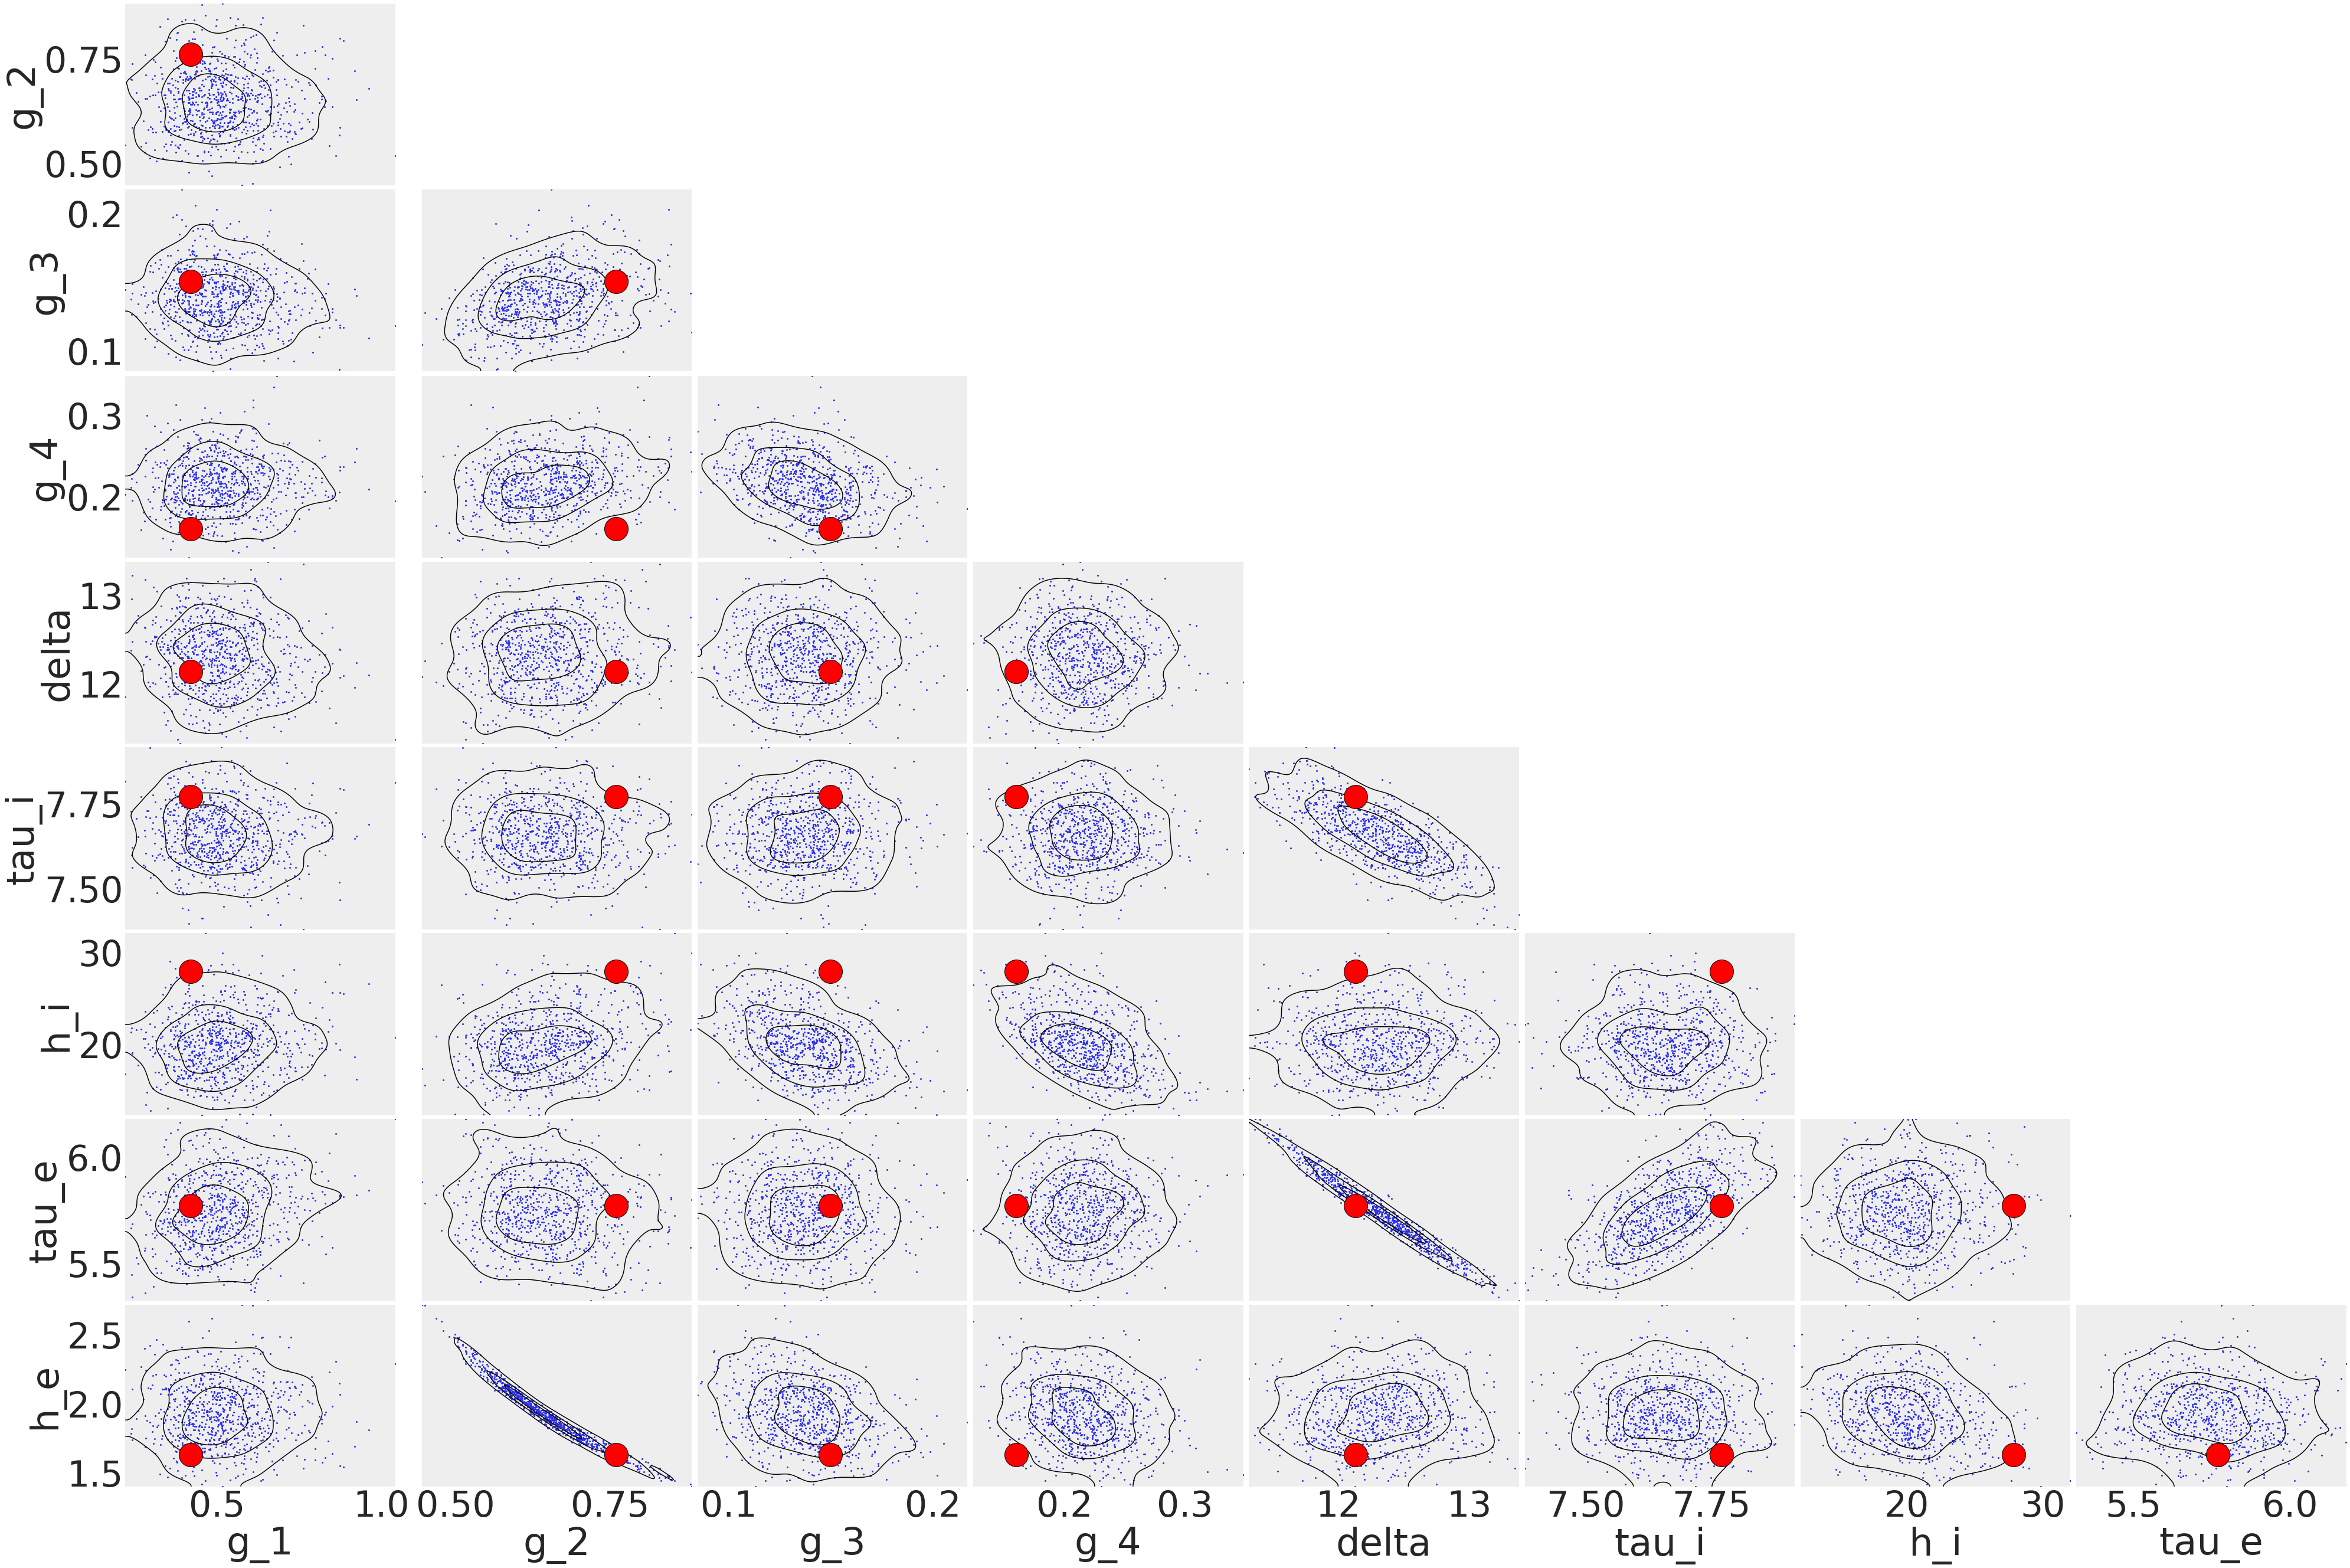

In [86]:
az.plot_pair(az_obj, var_names=my_var_names, 
            kind=["scatter", "kde"], textsize=60, divergences=True,
            kde_kwargs={"fill_last": False,     
            "hdi_probs": [0.3, 0.6, 0.9],  
            "contourf_kwargs": {"cmap": "Blues"} },
            reference_values=dict((zip(my_var_names, theta_true))), 
            reference_values_kwargs={'markersize':40, 'color': 'r', 'marker': 'o'}) ;

### Fit and Posterior predictive check of converged NUTS

In [87]:
az_obj.posterior['xpy_model'] = az_obj.posterior['x_hat']

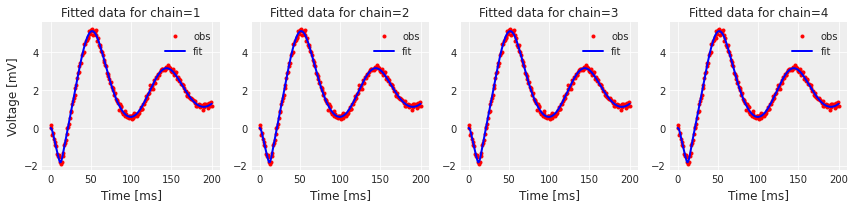

In [88]:
plot_fitted(data, az_obj.posterior)

### posterior prediction using pooled chains of convergenced NUTS

In [90]:
joint_sample_, ppc_, xpy_per5_, xpy_per95_, x_map_=out_of_samples_ppc_values(data, ERP_JAXOdeintSimuator, chains_pooled, n_)

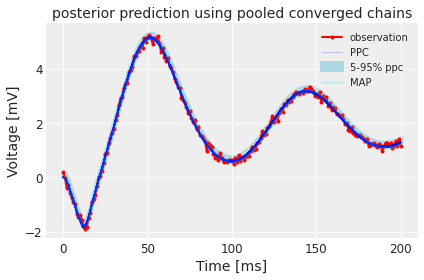

In [91]:
title='posterior prediction using pooled converged chains'
plot_out_of_sample_ppc_values(data, ERP_JAXOdeintSimuator,joint_sample_, xpy_per5_, xpy_per95_, x_map_, n_, title)

In [92]:
#! pip install watermark
%load_ext watermark
%watermark -n -u -v -iv -w

Last updated: Fri Apr 19 2024

Python implementation: CPython
Python version       : 3.10.12
IPython version      : 7.34.0

numpy     : 1.26.4
matplotlib: 3.5.2
arviz     : 0.17.0
jax       : 0.4.13
seaborn   : 0.13.2
sys       : 3.10.12 (main, Nov 20 2023, 15:14:05) [GCC 11.4.0]
cmdstanpy : 1.1.0

Watermark: 2.4.3

